## Bayesian Optimisation Verification

In [1]:
# import relevant packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error
from itertools import product
from gp_para import gp_tuning
# stop showing warning messages
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Seed for reproducibility
rng = np.random.default_rng(12345)

In [3]:
### Impot data for training and evaluation
# import data sheet (time:0~5000s) with temp 120, 140, 160, 180
address = 'data/degradation.xlsx'
y_normal = np.empty(shape=[0,1])
i = 3
list_temp = (120,140,160,180)
for temp in list_temp:
    df = pd.read_excel(address,sheet_name = 'normal data',usecols = [i],names = None,nrows = 5000)
    df = df.values.tolist()
    df = np.array(df)
    y_normal =  np.append(y_normal,df)
    i+=1

In [18]:
### Data setup 
# NUM_OF_DATA_POINTS must be an even number
NUM_OF_DATA_POINTS = 50
NUM_OF_PLOT_POINTS = 100
### Kernel setting and prediction
LOWEST_NOISE_LEVEL = 1e-16
HIGHEST_NOISE_LEVEL = 1e-12
KERNEL_ALPHA = 1e-15

################################################################################
# Data setup with half points evenly spread in 0-999, another half in 1000-4999
X_num = np.hstack([np.linspace(0,999,num=int(3*NUM_OF_DATA_POINTS/4),dtype=int),np.linspace(1000,4999,num=int(NUM_OF_DATA_POINTS/4),dtype=int)])

# Data setup with1/4 in 0-199, 2/4 in 200-999, 1/4 1000-4999
# X_num = np.hstack([ np.linspace(0,199,num=int(NUM_OF_DATA_POINTS/4),dtype=int),
#                     np.linspace(200,999,num=int(NUM_OF_DATA_POINTS/2),dtype=int),
#                     np.linspace(1000,4999,num=int(NUM_OF_DATA_POINTS/4),dtype=int)])

# Data setup with 2/5 in 0-99, 2/5 in 100-999, 1/5 1000-4999
X_num = np.hstack([ np.linspace(0,99,num=int(NUM_OF_DATA_POINTS*2/5),dtype=int),
                    np.linspace(199,999,num=int(NUM_OF_DATA_POINTS*2/5),dtype=int),
                    np.linspace(1000,4999,num=int(NUM_OF_DATA_POINTS*1/5),dtype=int)])

# Data setup with  points evenly spread 
# X_num = np.linspace(0,4999,num=int(NUM_OF_DATA_POINTS),dtype=int)

# Data setup with points spread in log space
# X_num = np.logspace(0,np.log10(4999), num=NUM_OF_DATA_POINTS, base=10.0, dtype=int)
# HIGHEST_NOISE_LEVEL = 1e-15
# KERNEL_ALPHA = 8e-5


In [19]:
X_ = np.arange(0,5000).astype(int)
x_normal = np.empty(shape=[0,2])
temp_list = np.array([120,140,160,180])

for temp in temp_list:
    df_temp = np.full((5000,1),temp)
    x_normal_partial = np.hstack([X_.reshape(5000,1),df_temp])
    x_normal =  np.concatenate([x_normal,x_normal_partial])

Y = y_normal[np.hstack([X_num,X_num+5000,X_num+5000*2,X_num+5000*3])]
X = np.empty(shape=[0,2])
for temp in temp_list:
    df_temp = np.full((int(NUM_OF_DATA_POINTS),1),temp)
    X_partial = np.hstack([X_num.reshape(int(NUM_OF_DATA_POINTS),1),df_temp])
    X = np.concatenate([X, X_partial])

In [20]:
### Kernel setting and prediction
# kernel_yc = 1.0 * RBF(length_scale=5) + WhiteKernel(noise_level=NOISE_LEVEL,
#         noise_level_bounds=[LOWEST_NOISE_LEVEL,HIGHEST_NOISE_LEVEL])
# alpha_space = np.logspace(-15, -2, 53)

# best_gp = gp_tuning(X, Y, kernel_length_scales=None,
#               alpha=alpha_space, noise_level_bounds=None,
#               noise_level = 1e-13, 
#               additional_kernels=None, starting_length_scale=3,
#               return_table=True, write_table=False,
#               table_name="bo_2d_models_table.csv", metric="log_marginal_likelihood",
#               return_instance=False)

# print("Learned kernel", best_gp)

In [21]:
gp = GaussianProcessRegressor(alpha= 1e-5, kernel=1.0 * RBF(length_scale = 0.27,length_scale_bounds=[0,1e5]) 
                                + WhiteKernel(noise_level=1e-16,noise_level_bounds=(1e-15,1e-11)))
gp.fit(X,Y)
print(gp)

GaussianProcessRegressor(alpha=1e-05,
                         kernel=1**2 * RBF(length_scale=0.27) + WhiteKernel(noise_level=1e-16))


<p> GaussianProcessRegressor(alpha=1e-05, kernel=1**2 * RBF(length_scale=0.5) + WhiteKernel(noise_level=1e-16))
</p>
<p> GaussianProcessRegressor(alpha=1e-05, kernel=1**2 * RBF(length_scale=0.27) + WhiteKernel(noise_level=1e-16))</p>



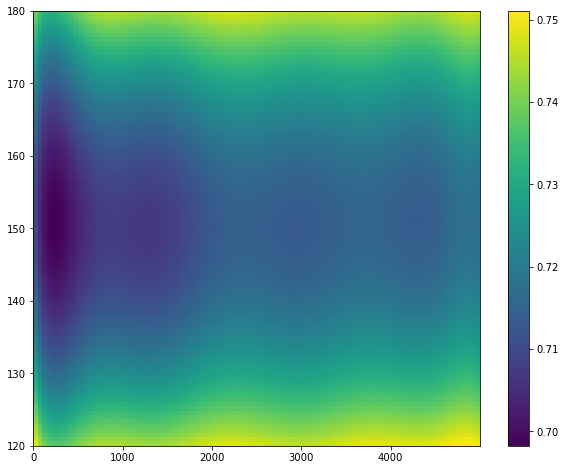

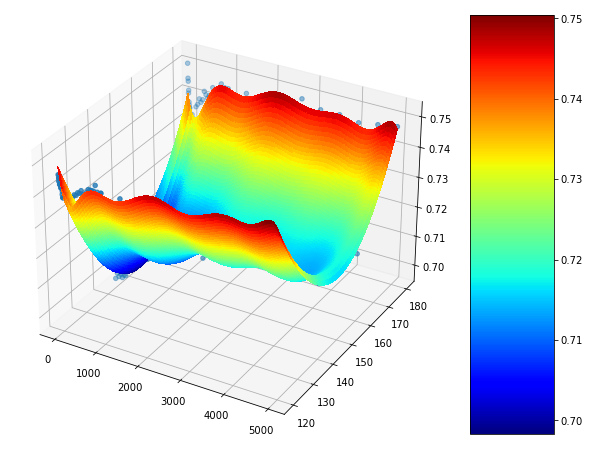

In [22]:
#### Plot
x1 = np.linspace(X[:,0].min(), X[:,0].max(),num = NUM_OF_PLOT_POINTS)
x2 = np.linspace(X[:,1].min(), X[:,1].max(),num = NUM_OF_PLOT_POINTS)
x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)
X0p, X1p = x1x2[:,0].reshape(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS), x1x2[:,1].reshape(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS)
Zp = np.reshape(y_pred,(NUM_OF_PLOT_POINTS,NUM_OF_PLOT_POINTS))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
pcm = ax.pcolormesh(X0p, X1p, Zp)
fig.colorbar(pcm, ax=ax)
plt.show()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')            
surf = ax.plot_surface(X0p, X1p, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
ax.scatter(X[:,0],X[:,1],Y)
fig.colorbar(surf, aspect=5)
plt.show()


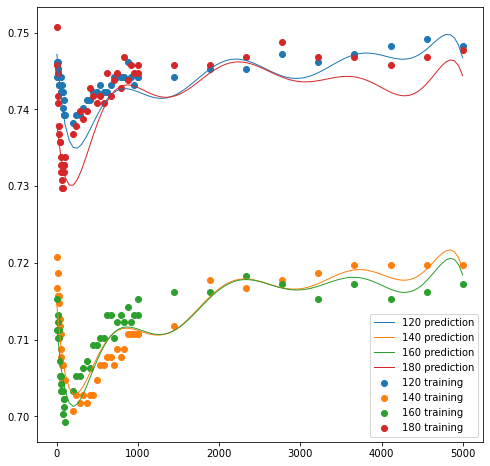

In [23]:
fig = plt.figure(figsize=(8,8))
i = 1
for temp in temp_list:
    plt.plot(x1,Zp[:,i],label = str(temp)+' prediction',lw=1)
    i += int(NUM_OF_PLOT_POINTS/3-1)
j = NUM_OF_DATA_POINTS
for temp in temp_list:
    plt.scatter (X_num,Y[j-NUM_OF_DATA_POINTS:j],label = str(temp)+' training')
    j += NUM_OF_DATA_POINTS
plt.legend()
plt.show()

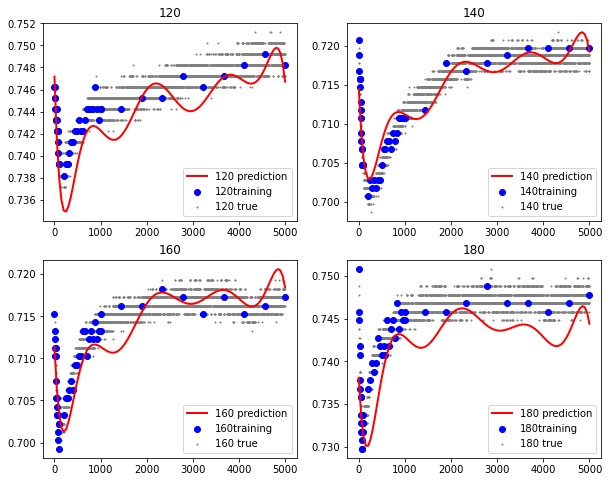

In [24]:
i = 1
j = NUM_OF_DATA_POINTS
k = 0
fig = plt.figure(figsize=(10,8))
plot_index = 1
for temp in temp_list:
    plt.subplot(2,2,plot_index),plt.plot(x1,Zp[:,i],label = str(temp)+' prediction',c='red',lw=2,zorder=3),
    plt.scatter (X_num,Y[j-NUM_OF_DATA_POINTS:j],label = str(temp)+'training',c='blue',zorder=2),
    plt.scatter(X_,y_normal[k:k+5000],label = str(temp)+' true',s=1,c='grey',zorder=1),
    plt.title(str(temp)),plt.legend(),plt.tight_layout

    i += int(NUM_OF_PLOT_POINTS/3-1)
    j += NUM_OF_DATA_POINTS
    k+=5000
    plot_index+=1
plt.show()